In [5]:
%autoreload 2
%matplotlib qt
%pylab
from conf_analysis.meg import preprocessing, artifacts
from conf_analysis.behavior import empirical, metadata, keymap
import mne, locale
import numpy as np
import copy
import seaborn as sns
import cPickle
    
sns.set_style('ticks')
_ = locale.setlocale(locale.LC_ALL, "en_US")

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


/Users/nwilming/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# The big picture

My data comes in a bunch of different files that need to be combined:

<img src="http://localhost:8888/notebooks/conf_analysis/notebooks/data.png" align="left" height="400">

Things I'm not going to show to you:
    1. How to convert analog gaze voltages to screen positions.
    2. How to convert matlab files into a pandas data frame.
    3. Parse triggers from the MEG 
  
Instead I'll show how to preprocess one of the yellow blocks up there.

## 1. Load behavioral data

In [96]:
snum = 1
session = 2
filename = metadata.get_raw_filename(snum, session)
data = empirical.load_data()
data = empirical.data_cleanup(data)

In [97]:
print filename
# Behavioral data
data = data.query('snum==%i & session_num==%i'%(snum, session+1))
(data.loc[:, 
        ['choice_rt', 'confidence', 'correct', 'response', 'trial', 'hash', 'snum', 'session']]
    .set_index('hash')
    .head())

/Volumes/dump/conf_data/raw/s01-03_Confidence_20151216_01.ds


,choice_rt,confidence,correct,response,trial,snum,session
hash,,,,,,,
1501,0.352040,1.0,1.0,1.0,0,1,20151216T082422
1502,0.548225,1.0,0.0,-1.0,1,1,20151216T082422
1503,0.317548,1.0,0.0,-1.0,2,1,20151216T082422
1504,0.541085,2.0,1.0,1.0,3,1,20151216T082422
1505,0.395318,2.0,1.0,-1.0,4,1,20151216T082422


## 2. Load a .ds directory

In [104]:
mne.set_log_level('WARNING')
raw = mne.io.read_raw_ctf(filename, system_clock='ignore')
print raw

<RawCTF  |  s01-03_Confidence_20151216_01.meg4, n_channels x n_times : 401 x 5588400 (4657.0 sec), ~1.3 MB, data not loaded>


In [100]:
# Get data for UADC002 - one of the eye tracking channels
uad_idx = where(array(raw.ch_names)==u'UADC002-3705')[0]
d, t = raw[uad_idx, 10000:20000]
plot(t, d.ravel())

In [101]:
# Parse triggers
trials = preprocessing.blocks(raw)

In [105]:
# Cut out first block.
raw, r_id = preprocessing.load_block(raw, trials, 1)

In [ ]:
raw.crop(0, 100)

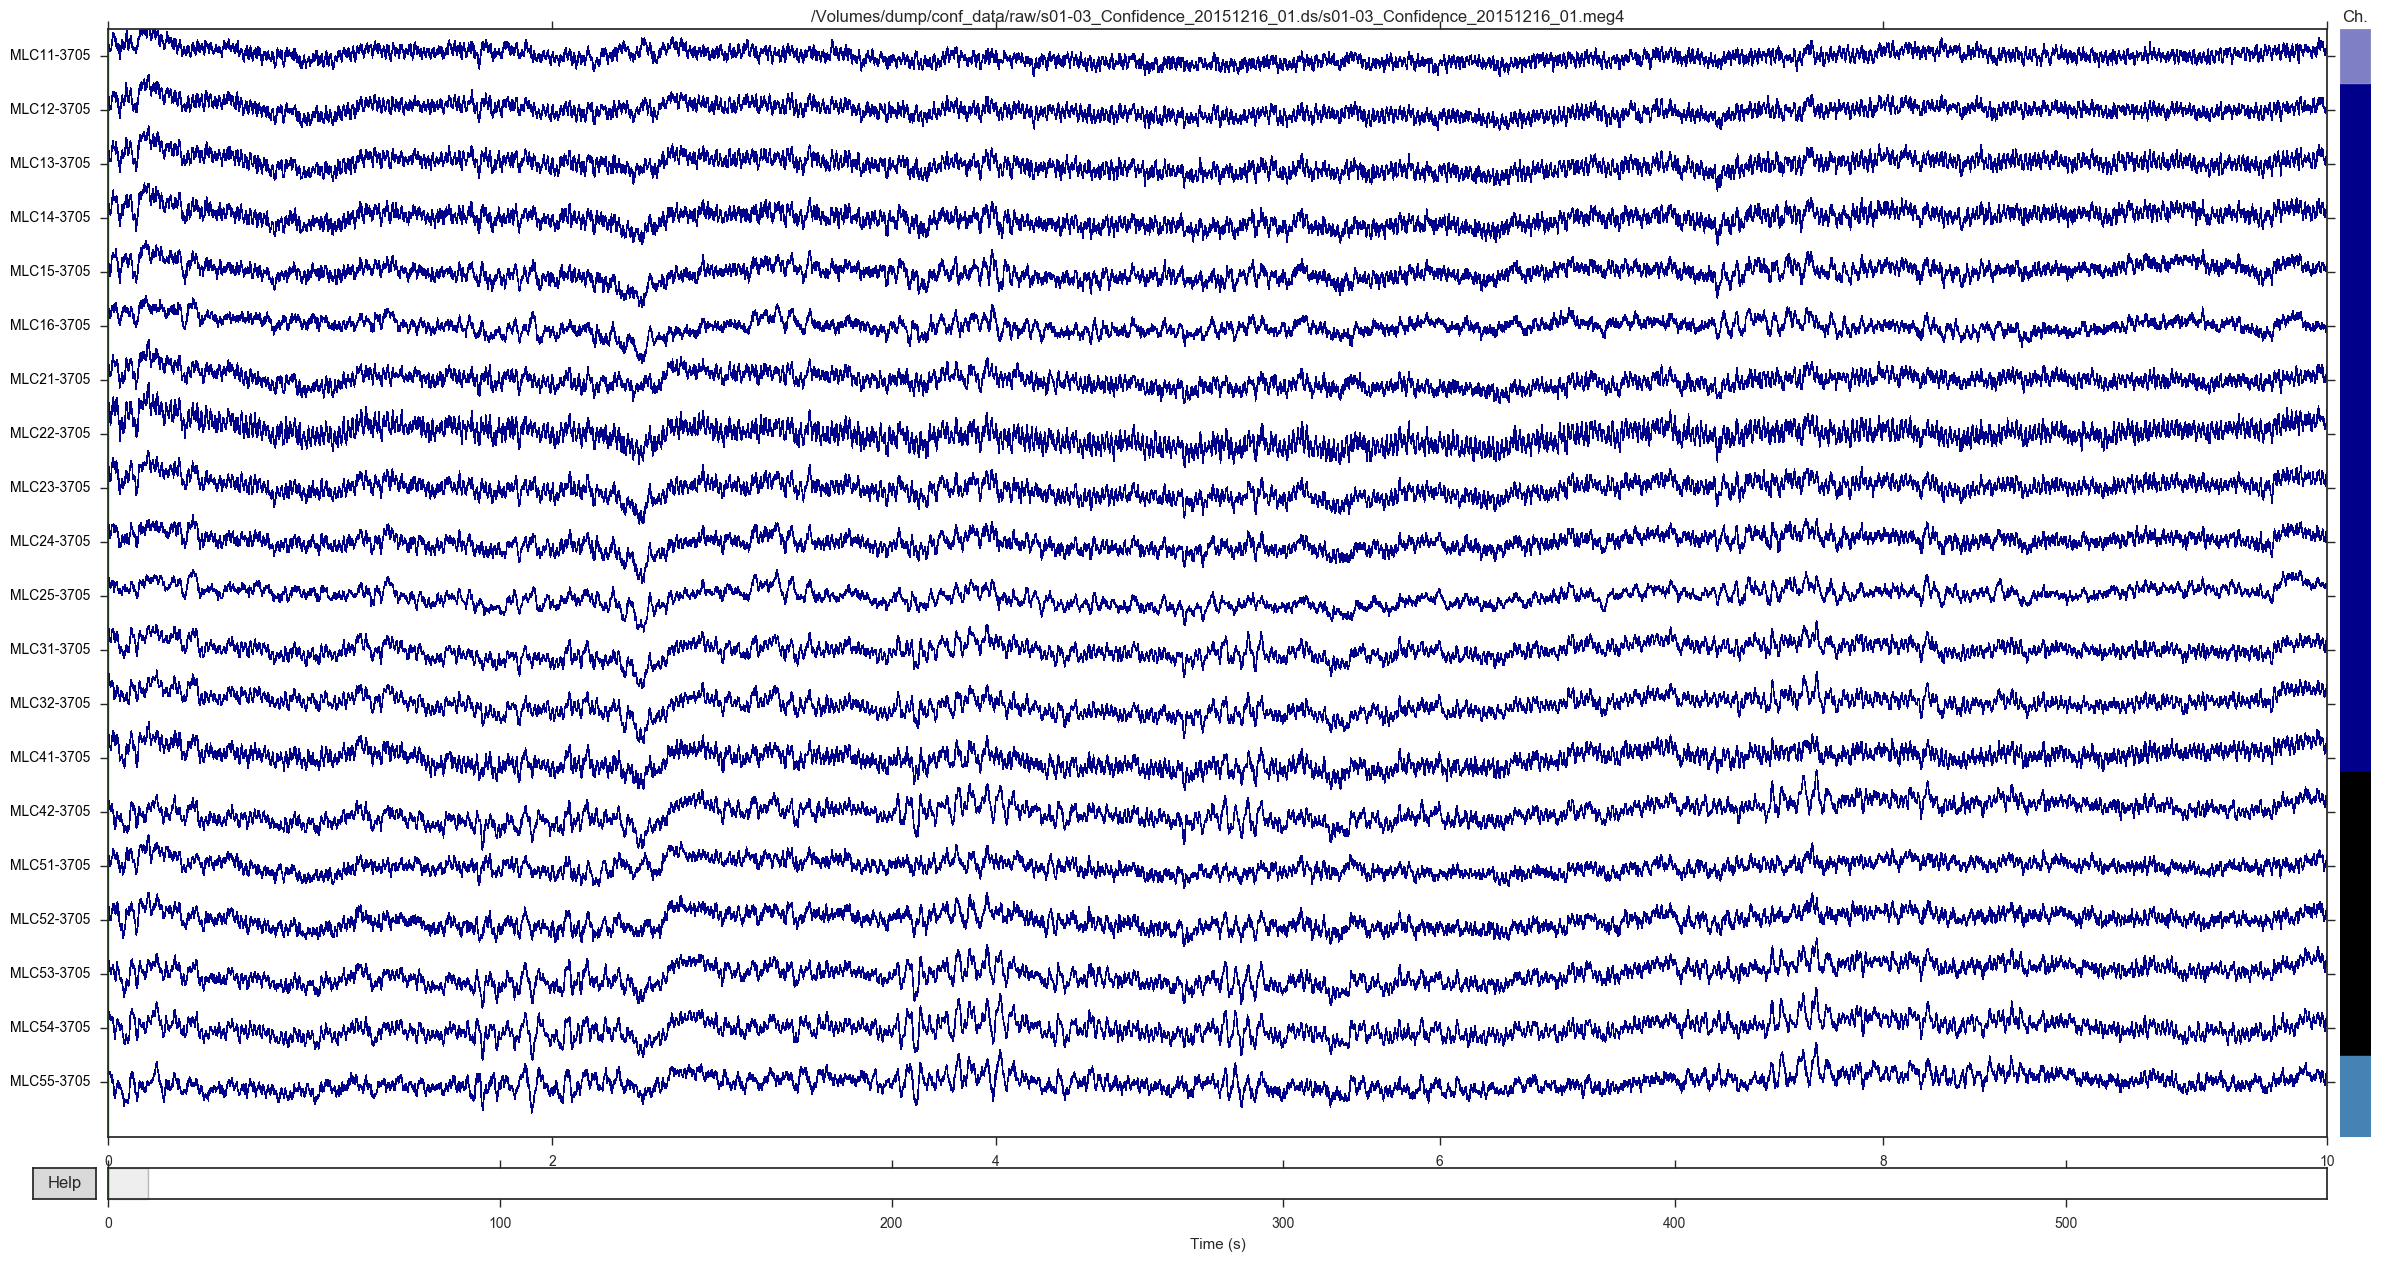

In [106]:
raw.plot()

# Artifact detection

Consider this from the fieldtrip docs:
```
  The data is preprocessed (again) with the following configuration parameters,
  which are optimal for identifying muscle artifacts.
    cfg.artfctdef.muscle.bpfilter    = 'yes'
    cfg.artfctdef.muscle.bpfreq      = [110 140]
    cfg.artfctdef.muscle.bpfiltord   = 8
    cfg.artfctdef.muscle.bpfilttype  = 'but'
    cfg.artfctdef.muscle.hilbert     = 'yes'
    cfg.artfctdef.muscle.boxcar      = 0.2
  
  ... ca. 20 parameters follow.
  
```

My goal was to have something much more opaque with much less parameters. 

## Blink detection on EL1000+ data

1. Conversion of analog eye data to screen units.
2. Detect saccades with velocity (>30°/s) and acceleration (>2000°/$s^2$) threshold.
3. Blinks are surrounded by saccades and the ey position is off screen.


In [107]:
# Detect eye blinks from EyeLink AD Data in raw file
%time ab = artifacts.annotate_blinks(raw)

CPU times: user 456 ms, sys: 88.7 ms, total: 545 ms
Wall time: 542 ms


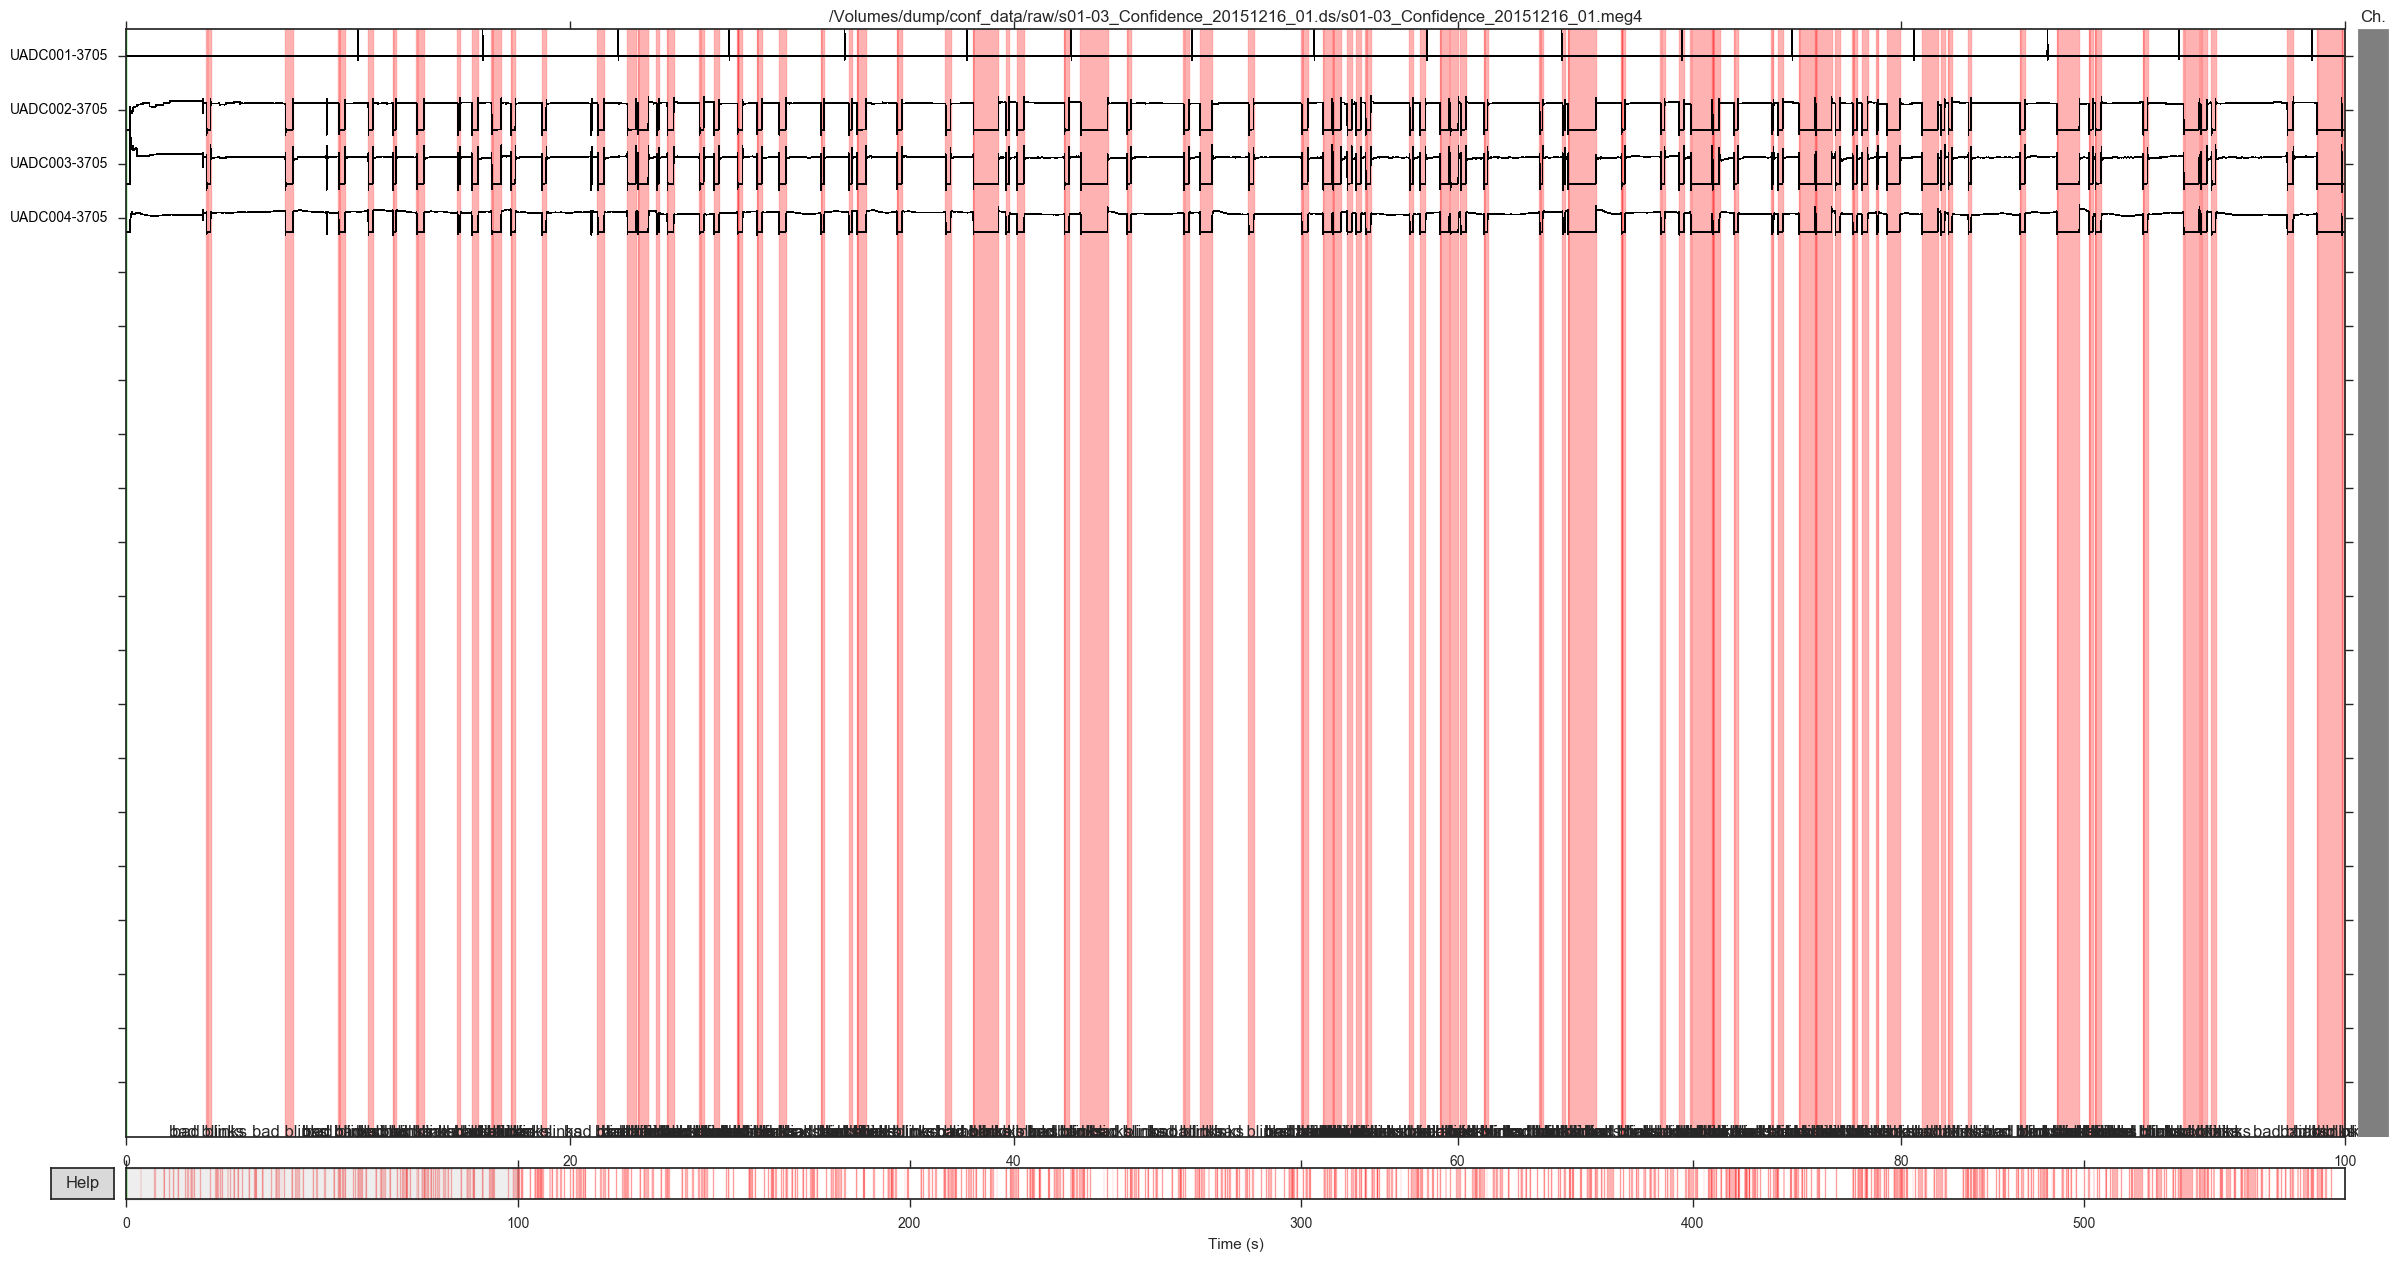

In [108]:
ab_aligned = copy.deepcopy(ab)
r = raw.copy()
ab_aligned.onset += r.first_samp/1200. # Need to take onset of recording into account
r.annotations = ab_aligned
r.load_data()
r.pick_channels([ch for ch in r.ch_names if 'UAD' in ch])
r.plot(duration=100, scalings='auto')

## Detect Muscle artifacts

This generally follows the fieldtrip approach.

1. Bandpass filter channels between 110 and 140Hz
2. Compute power envelope (Hilbert transform). This allows to combine channels that are not phase locked.
3. Scale channels appropriately, compute mean of squared signal and scale again.
4. Threshold the resulting time-series.

Notable differences are: I filter 10 minute segments of data (blocks of 100 trials) and use the entire data segment for filtering. I believe that this makes the approach more robust, because we potentially get a better estimate of the signal distribution and we can get rid of most padding parameters.

Instead of z-scoring I chose to normalize the data such that 90% of the data are in [-1, 1] or 80% in [0, 1]. Artifact detection is intrinsically outlier detection, which implies that medians and quartiles are more appropriate since they are less affected by outliers in the data.

In [109]:
%time am, zm = artifacts.annotate_muscle(raw, cutoff=7.5)

The default output type is "ba" in 0.13 but will change to "sos" in 0.14


/Users/nwilming/u/conf_analysis/meg/artifacts.py:323: RuntimeWarning: The default output type is "ba" in 0.13 but will change to "sos" in 0.14
  del filt


CPU times: user 1min 28s, sys: 21.4 s, total: 1min 49s
Wall time: 1min 20s


In [110]:
figure()
plot(arange(len(zm))/1200., zm)
axhline(10, color='r')
ylim([0, 11])

(0, 11)

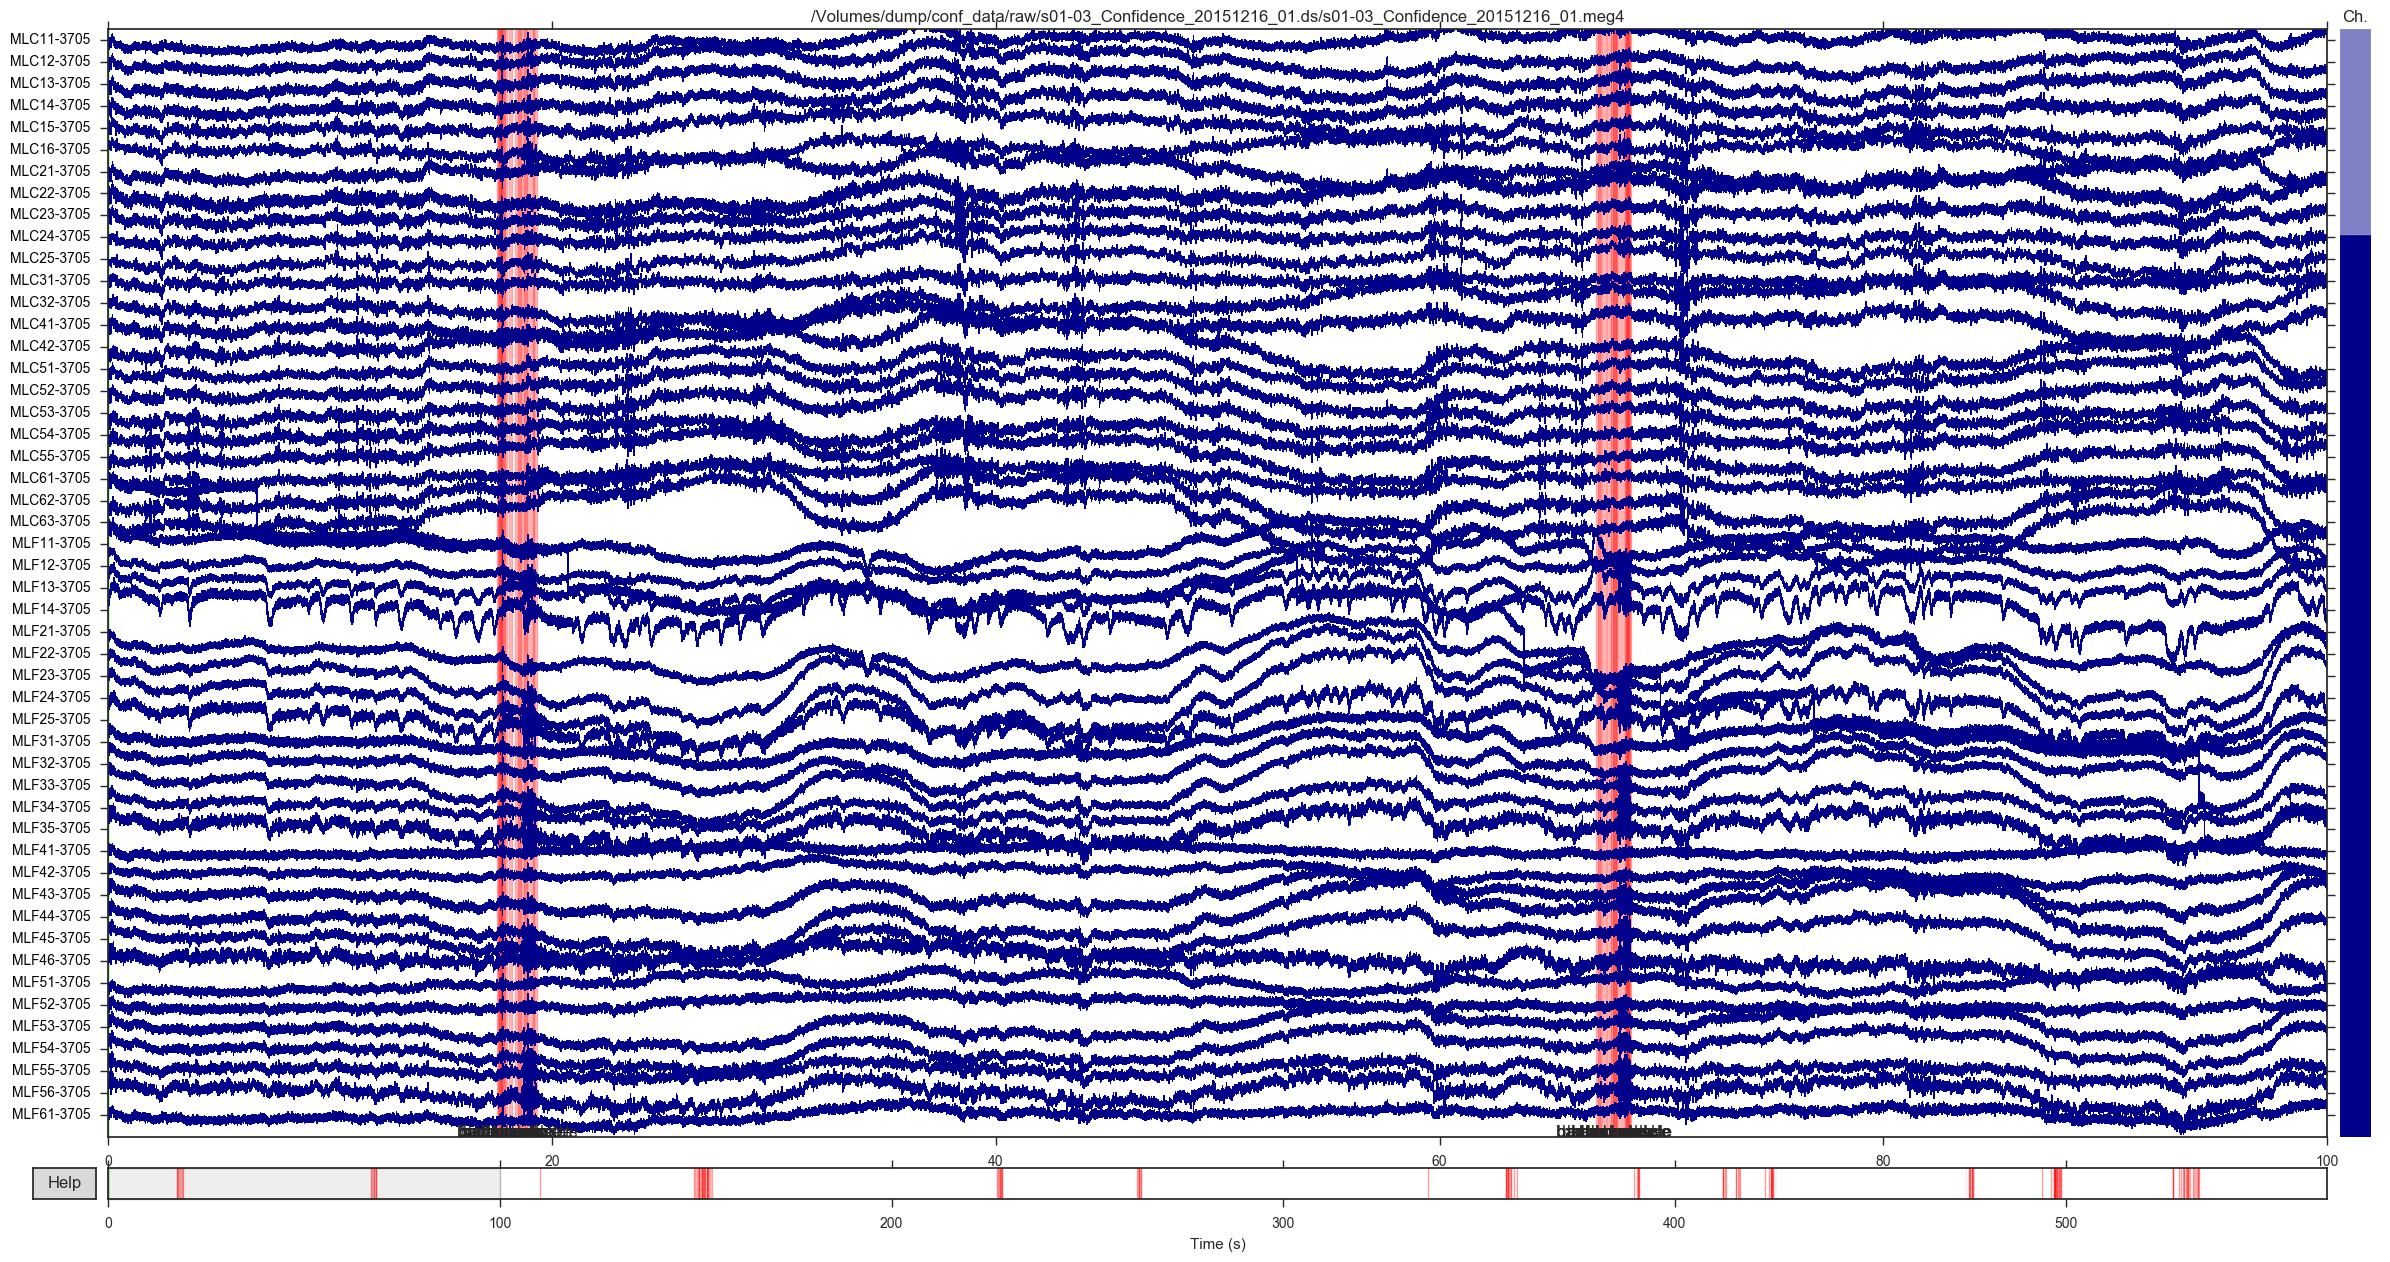

In [111]:
ab_aligned = copy.deepcopy(am)
ab_aligned.onset += r.first_samp/1200. # Need to take onset of recording into account
r = raw.copy()
r.annotations = ab_aligned

r.load_data()
r.pick_channels([ch for ch in r.ch_names if ch.startswith('M')])
r.plot(n_channels=50, duration=100)

## Car detection

Same approach as muscle detection but use low-pass filter at 1Hz. My guess is that the street in front of the MEG where cars have a visible effect is ca. 20m long and cars travel at most with a speed of 40km/h which yields a min. passing time of ~ 1.8s. So 1Hz should be fine.

In [112]:
%time ac, zc, zcd = artifacts.annotate_cars(raw, cutoff=3, der_cutoff=4.)

Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14


/Users/nwilming/u/conf_analysis/meg/artifacts.py:286: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  d[:raw.info['sfreq']]=0
/Users/nwilming/u/conf_analysis/meg/artifacts.py:287: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  d[-raw.info['sfreq']:]=0


CPU times: user 1min 42s, sys: 23.3 s, total: 2min 6s
Wall time: 1min 37s


In [113]:
plot(arange(len(zm))/1200., zc)
plot(arange(len(zm))/1200., zcd, ':')

for start, dur in zip(ac.onset, ac.duration):
    plot([start, start+dur], [0, 0], 'r', lw=2)
    
axhline(3, color='k')
axhline(4, color='k', ls=':')
axhline(-4, color='k', ls=':')
ylim([-10, 10])

(-10, 10)

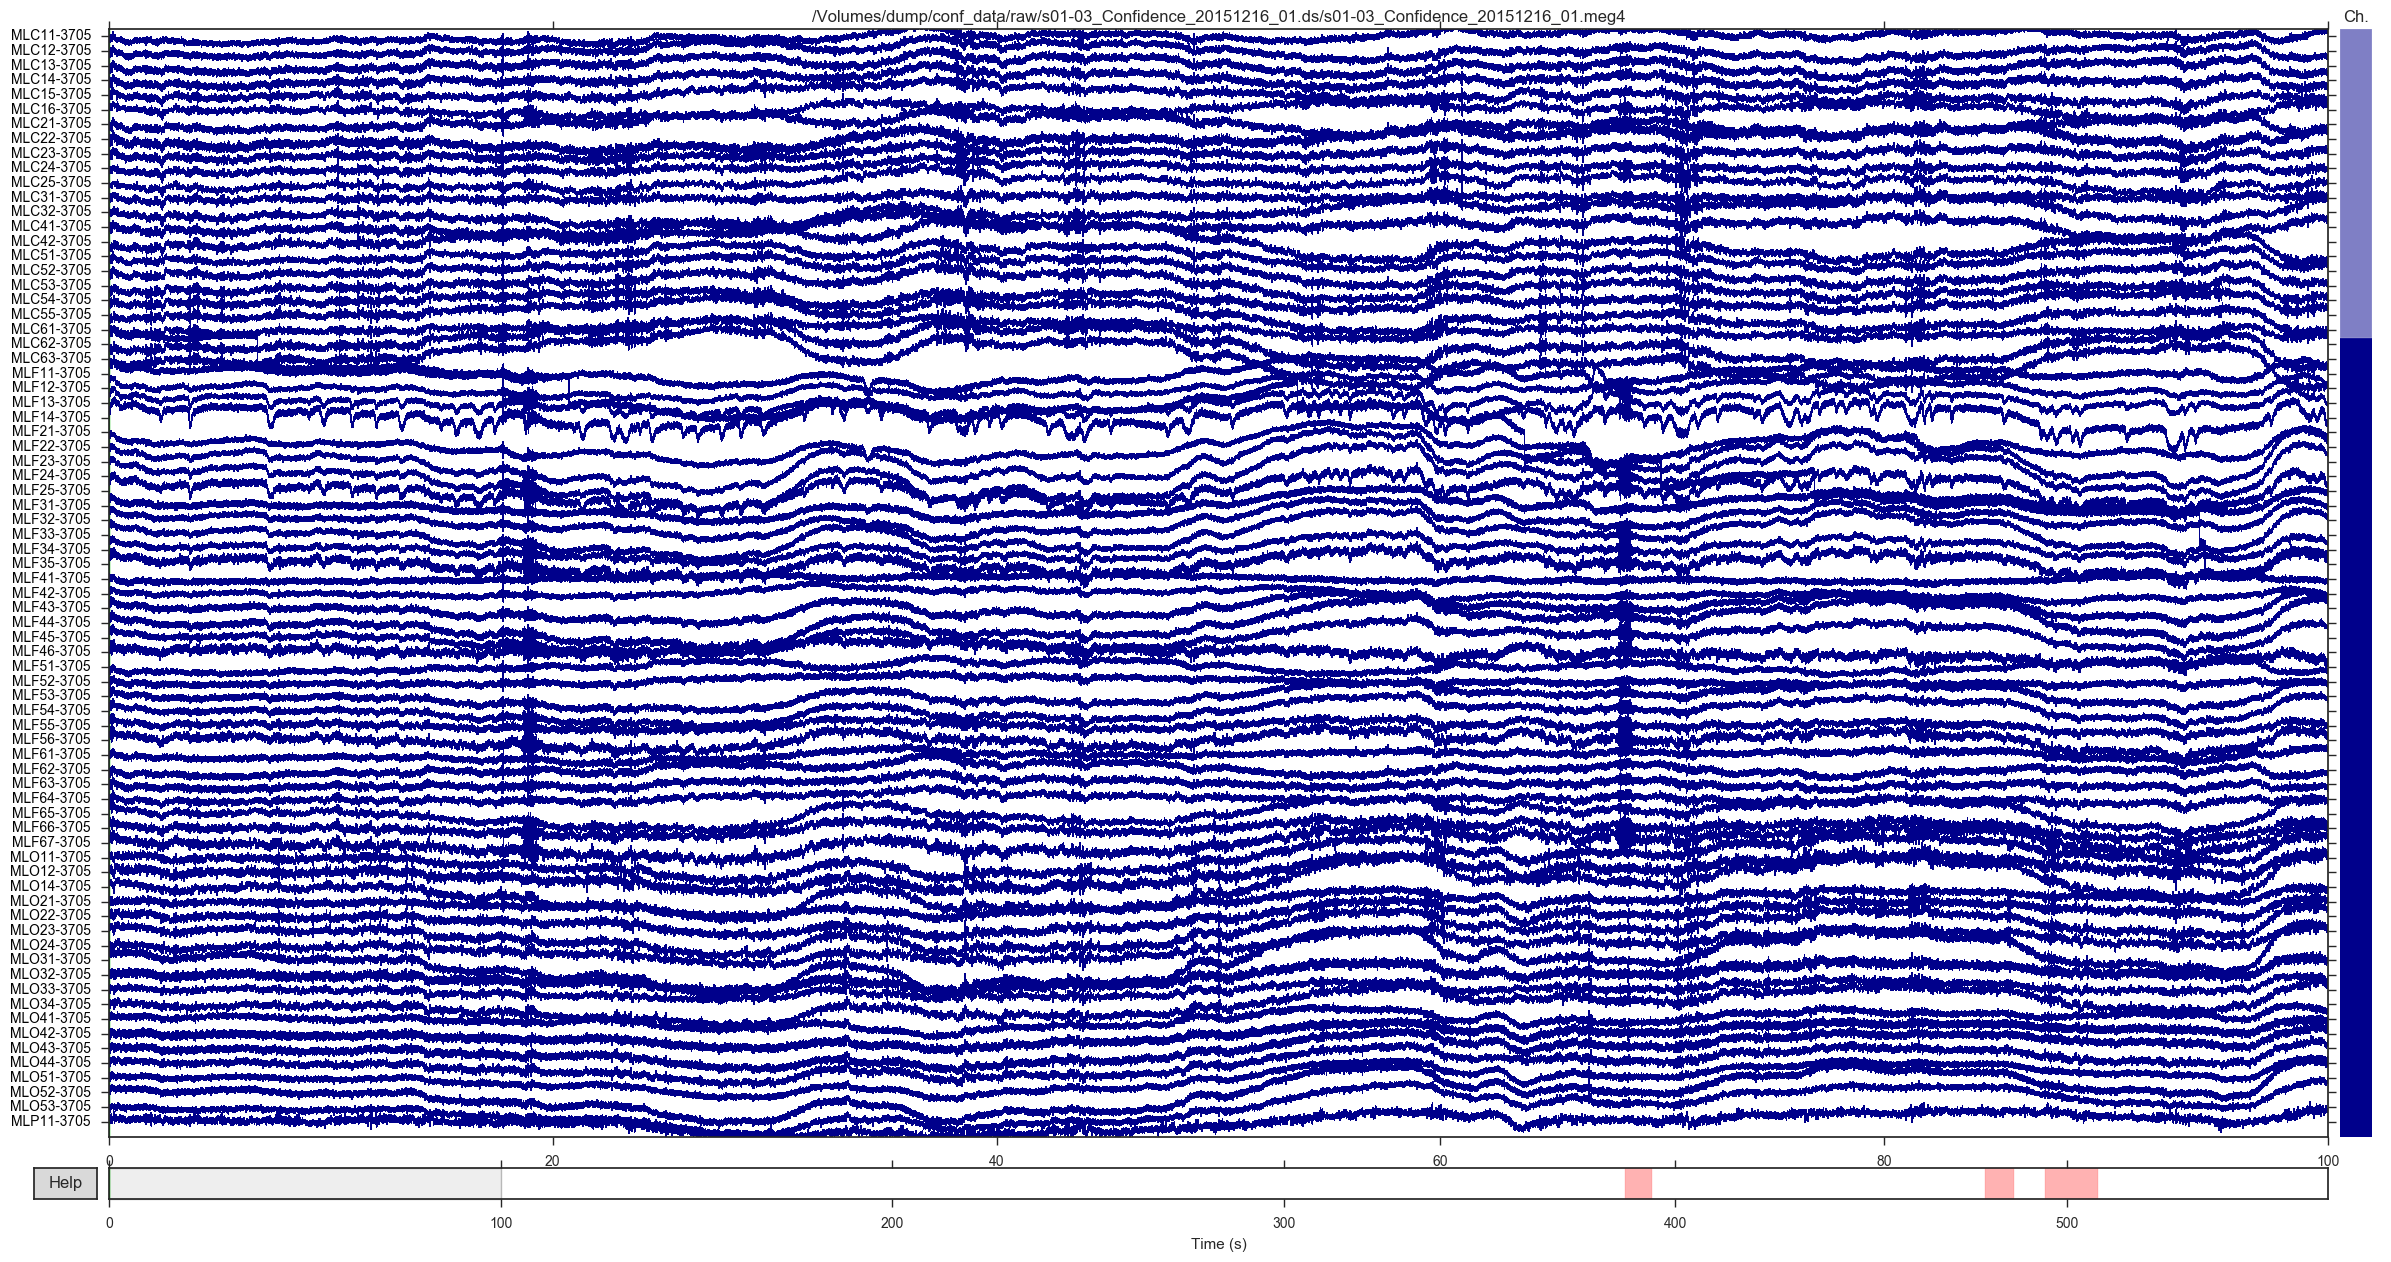

In [114]:
ab_aligned = copy.deepcopy(ac)
ab_aligned.onset += r.first_samp/1200. # Need to take onset of recording into account
r.annotations = ab_aligned
r.load_data()
r.pick_channels([ch for ch in r.ch_names if ch.startswith('M')])
r.plot(n_channels=75, duration=100)

## Jump detection

This works differently since the way how jumps affect the data are very different. A jump is by definition a change in mean value of one channel within a few samples, and this is the pattern that I look for in each channel. To this end I convolve each channel with a 'jump' detection kernel:

![Detection kernel](fig1.png)

In [115]:
%time ar, zj = artifacts.annotate_jumps(raw)

Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14
CPU times: user 42.3 s, sys: 15.6 s, total: 58 s
Wall time: 1min 4s


In [116]:
figure()
plot(arange(len(zm))/1200., zj)
axhline(25, color='k')
ylim([-1, 50])

(-1, 50)

In [117]:
figure()
ab_aligned = copy.deepcopy(ar)
r = raw.copy()
r.annotations = ab_aligned
r.load_data()
r.pick_channels([ch for ch in r.ch_names if ch.startswith('MLF21')])
plot(r.times, r._data[0,:])
for start, dur in zip(ab_aligned.onset, ab_aligned.duration):
    axvline(start, color='r')
    axvline(start+dur, color='r')
sns.despine()

## How to pick thresholds?

I hoped for some bimodal distribution of feature detector values, but this was not the case.

In [118]:
import cPickle
hists = cPickle.load(open('/Users/nwilming/u/conf_analysis/art_hists.pickle'))

In [119]:
figure()
edges = np.array(list(linspace(0, 50, 2001)) + [100000000])
centers = cumsum(diff(edges))
for i,d in enumerate(hists):
    h = d['muscle']
    h = h.astype(float)/sum(h)
    axvline(centers[argmin(abs(cumsum(h)-0.8))], color='k')
    axvline(centers[argmin(abs(cumsum(h)-0.95))], color='k', alpha=0.25)

    plot(centers, h, '-', label=i+1)
xlim(0, 10)
ylim(0.0, 0.1)
ylabel('#')
xlabel('Normalized feature value')
legend()
sns.despine()
tight_layout()

# Epoch data

In [120]:
meta, timing = preprocessing.get_meta(data, raw, snum, 0)

/Volumes/dump/conf_data/raw/s01-03_Confidence_20151216_01.ds


In [92]:
meta.head()

end  ref_offset  ref_onset     start  \
day      block_num trial                                              
20151216 0         0.0    475817.0          49         64  468723.0   
                   1.0    482557.0          49         64  475857.0   
                   2.0    489897.0          49         64  482597.0   
                   3.0    495897.0          49         64  489937.0   
                   4.0    502137.0          49         64  495937.0   

                          stim_offset  stim_onset  index  choice_rt  \
day      block_num trial                                              
20151216 0         0.0             48          64      0   0.352040   
                   1.0             48          64      1   0.548225   
                   2.0             48          64      2   0.317548   
                   3.0             48          64      3   0.541085   
                   4.0             48          64      4   0.395318   

                          confidence  contrast  ...  repeated_stim  response  \
day      block_num trial                        ...                            
20151216 0         0.0           1.0  0.286817  ...            NaN       1.0   
                   1.0           1.0  0.278375  ...            NaN      -1.0   
                   2.0           1.0  0.269233  ...            NaN      -1.0   
                   3.0           2.0  0.259563  ...            NaN       1.0   
                   4.0           2.0  0.252180  ...            NaN      -1.0   

                                  session  side  snum        mc      stdc  \
day      block_num trial                                                    
20151216 0         0.0    20151216T082422     1     1  0.820466  0.074949   
                   1.0    20151216T082422     1     1  0.792681  0.160052   
                   2.0    20151216T082422     1     1  0.762447  0.051109   
                   3.0    20151216T082422     1     1  0.790940  0.114759   
                   4.0    20151216T082422    -1     1  0.244491  0.041845   

                            R session_num  hash  
day      block_num trial                         
20151216 0         0.0    1.0           3  1501  
                   1.0    0.0           3  1502  
                   2.0    0.0           3  1503  
                   3.0    1.0           3  1504  
                   4.0    0.0           3  1505  

[5 rows x 26 columns]

In [93]:
timing.head()

button_t   cc0_t   cc1_t   cc2_t   cc3_t   cc4_t  \
day      block_num trial                                                     
20151216 0         0.0      474388  472762  472878  472997  473117  473238   
                   1.0      481759  479901  480017  480137  480257  480377   
                   2.0      488202  486621  486737  486857  486977  487097   
                   3.0      494790  492941  493057  493177  493297  493417   
                   4.0      500795  499121  499237  499357  499477  499597   

                           cc5_t   cc6_t   cc7_t   cc8_t   cc9_t  \
day      block_num trial                                           
20151216 0         0.0    473357  473477  473597  473717  473837   
                   1.0    480497  480617  480737  480857  480977   
                   2.0    487217  487337  487457  487577  487697   
                   3.0    493537  493657  493777  493897  494017   
                   4.0    499717  499837  499957  500077  500197   

                          meg_feedback_t  meg_noise_sigma_t  ref_offset_t  \
day      block_num trial                                                    
20151216 0         0.0          475216.0             468741        470977   
                   1.0          481955.0             475875        478117   
                   2.0          489294.0             482615        484857   
                   3.0          495295.0             489955        491677   
                   4.0          501533.0             495954        497777   

                          ref_onset_t  stim_offset_t  stim_onset_t  
day      block_num trial                                            
20151216 0         0.0         470498         473957        472758  
                   1.0         477637         481097        479897  
                   2.0         484377         487817        486617  
                   3.0         491197         494137        492937  
                   4.0         497297         500317        499117

In [94]:
# Define stimulus epochs.
m, s = preprocessing.get_epoch(raw, meta, timing,
                               event='stim_onset_t', epoch_time=(-.2, 1.5),
                               base_event='stim_onset_t', base_time=(-.2, 0))

In [122]:
print s

<Epochs  |  n_events : 100 (all good), tmin : -0.2 (s), tmax : 1.5 (s), baseline : None, ~464.9 MB, data loaded,
 '1501': 1, '1502': 1, '1503': 1, '1504': 1, '1505': 1, '1506': 1, '1507': 1, '1508': 1, '1509': 1, '1510': 1, '1511': 1, '1512': 1, '1513': 1, '1514': 1, '1515': 1, '1516': 1, '1517': 1, '1518': 1, '1519': 1, '1520': 1, '1521': 1, '1522': 1, '1523': 1, '1524': 1, '1525': 1, '1526': 1, '1527': 1, '1528': 1, '1529': 1, '1530': 1, '1531': 1, '1532': 1, '1533': 1, '1534': 1, '1535': 1, '1536': 1, '1537': 1, '1538': 1, '1539': 1, '1540': 1, '1541': 1, '1542': 1, '1543': 1, '1544': 1, '1545': 1, '1546': 1, '1547': 1, '1548': 1, '1549': 1, '1550': 1, '1551': 1, '1552': 1, '1553': 1, '1554': 1, '1555': 1, '1556': 1, '1557': 1, '1558': 1, '1559': 1, '1560': 1, '1561': 1, '1562': 1, '1563': 1, '1564': 1, '1565': 1, '1566': 1, '1567': 1, '1568': 1, '1569': 1, '1570': 1, '1571': 1, '1572': 1, '1573': 1, '1574': 1, '1575': 1, '1576': 1, '1577': 1, '1578': 1, '1579': 1, '1580': 1, '1581'

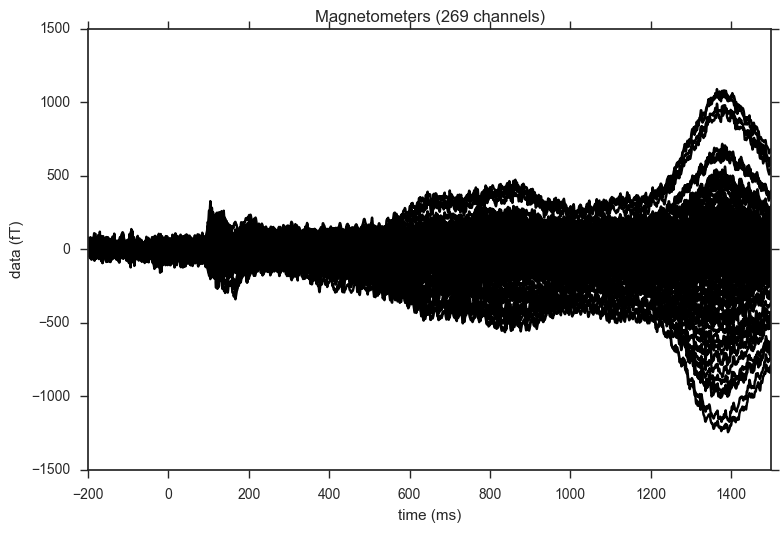

In [121]:
s.average().plot()